In [1]:
from validphys.api import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from gen_dicts import generate_dicts
from utils import XGRID
from model_utils import *

Using Keras backend


In [2]:
seed = 14132124
DEBUG = False

In [3]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=40000000,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [4]:
# Retrieve data from NNPDF
groups_data = API.procs_data(**common_dict)
tuple_of_dicts = generate_dicts(groups_data)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data

In [5]:
C_sys = API.dataset_inputs_t0_covmat_from_systematics(**common_dict)
C = API.groups_covmat_no_table(**common_dict)

# Serialize covmat
C.to_pickle(path='./serialised_data/covmat.pkl')
C_index = C.index
C_col = C.columns
#C = pd.DataFrame(C_sys, index=C_index, columns=C_col)
#C = pd.DataFrame(np.identity(C.shape[0]), index=C_index, columns=C_col)
Cinv = np.linalg.inv(C)
Cinv = pd.DataFrame(Cinv, index=C_index, columns=C_col)


L = np.linalg.cholesky(Cinv)
L = L.T
Linv = np.linalg.inv(L)

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


In [6]:
# Construct the big FK table matrix
ndata = 0
dataname_from_covmat = Cinv.index.get_level_values('dataset').unique()

vecs_for_stack = []
for i, (exp, fk) in enumerate(fk_table_dict.items()):
  ndata += fk.shape[0]
  if exp == dataname_from_covmat[i]:
    vecs_for_stack.append(fk.numpy().reshape((fk.shape[0], fk.shape[1] * fk.shape[2])))
  else:
    raise ValueError(f'Problem encountered {exp} != {dataname_from_covmat[i]}')

FK = np.vstack([fk.numpy().reshape((fk.shape[0], fk.shape[1] * fk.shape[2])) for fk in fk_table_dict.values()])
FK_plus = np.linalg.pinv(FK, rcond=1.e-3)
#FK = np.vstack(vecs_for_stack)

try:
  assert(FK.shape[0] == ndata)
except AssertionError:
  print('The number of points does not match.')

# Check that this FK is what we expect
try:
  test_matrix = np.random.rand(FK.shape[0], FK.shape[0])
  # Matrix product
  mat_prod = FK.T @ test_matrix

  # Tensor product
  shape = (*fk.shape[1:], *fk.shape[1:])
  result = np.zeros((fk.shape[1], fk.shape[2], FK.shape[0]))
  I = 0
  for fk in fk_table_dict.values():
    ndata = fk.shape[0]
    result += np.einsum('Iia, IJ -> iaJ',fk, test_matrix[I : I + ndata, :])
    I += ndata
  
  result_flatten = result.reshape((result.shape[0] * result.shape[1], result.shape[2]))
  assert(np.allclose(result_flatten, mat_prod))
  assert(np.allclose(result, mat_prod.reshape((result.shape[0], result.shape[1], result.shape[2]))))
except AssertionError:
  print('A problem occurred')

# Perform singular value decomposition
fk_l, fk_evals, fk_r = np.linalg.svd(FK)
#print('Singular values of the FK tables')
#print('--------------------------------')
#for idx, val in enumerate(fk_evals):
#  print(f'{idx} : {val}')

In [7]:
# Generate the model and compute the NTK
nrep = 1
nnpdf_models = [generate_sequential_model(outputs=9, nlayers=2, units=[28, 20],seed=seed + i, name='NNPDF', kernel_initializer='RandomNormal', predictions=False, dtype='float32') for i in range(nrep)]
NTK_rep = [compute_ntk(nnpdf, XGRID, round_to_zero=True, only_diagonal=True) for nnpdf in nnpdf_models]

# Flatten NTK
prod = 1
oldshape = NTK_rep[0].shape
for k in oldshape[2:]:
    prod *= k
NTK_rep_flat = [np.array(ntk).reshape(prod,-1) for ntk in NTK_rep]

# Compute mean
NTK_mean_flat = np.mean(NTK_rep_flat, axis=0)

# Compute predictions at initialization
f0_rep = [nnpdf(XGRID).numpy() for nnpdf in nnpdf_models]

# GD training

In [8]:
X = tf.convert_to_tensor(XGRID)
X = tf.reshape(X, shape=(-1,1))

nrep = 1
nnpdf_w_preds_reps = [generate_sequential_model(outputs=9, nlayers=2, units=[28, 20],seed=seed + i, name='NNPDF', kernel_initializer='RandomNormal', predictions=True, fk_table_dict=fk_table_dict, dtype='float32') for i in range(nrep)]
predictions = [nnpdf_w_preds(X) for nnpdf_w_preds in nnpdf_w_preds_reps]
results_by_rep = []

# Define optimizer
learning_rate_gd = 0.00000001

for i in range(len(nnpdf_w_preds_reps)):
  print(f'Loop : {i}')
  optimizer = tf.optimizers.SGD(learning_rate=learning_rate_gd)
  results_by_rep.append(train_network(model=nnpdf_w_preds_reps[i], 
                                      show_log=True, 
                                      optimizer=optimizer, 
                                      input_model=X, 
                                      Cinv=Cinv, 
                                      data=central_data_dict))

Loop : 0
------------------------
Step 0, Loss: 202768.375
------------------------
Step 100, Loss: 130019.1484375
------------------------
Step 200, Loss: 103538.5546875
------------------------
Step 300, Loss: 84320.0546875
------------------------
Step 400, Loss: 70326.546875
------------------------
Step 500, Loss: 60074.46484375
------------------------
Step 600, Loss: 52500.63671875
------------------------
Step 700, Loss: 46849.98828125
------------------------
Step 800, Loss: 42587.75390625
------------------------
Step 900, Loss: 39334.57421875


# Check evolution of the NTK

In [9]:
# ntk_aver_by_steps = []
# ntk_frob_reps_by_steps = []
# 
# for step in range(len(results_by_rep[0][3])):
#   ntk_aver = np.zeros_like(results_by_rep[0][0][0])
#   ntk_frob_reps = []
#   for rep in range(nrep):
#     ntk_aver += results_by_rep[rep][0][step]
#     ntk_frob_reps.append(np.linalg.norm(results_by_rep[rep][0][step], ord='fro') / 450)
#   ntk_frob_reps_by_steps.append(ntk_frob_reps)
# 
#   ntk_aver = ntk_aver / nrep
#   ntk_aver_by_steps.append(ntk_aver)
# 
# ntk_frob_reps_by_steps = np.array(ntk_frob_reps_by_steps)

delta_ntk_frob_means_by_steps = []
delta_ntk_frob_std_by_steps = []

for step in range(1, len(results_by_rep[0][3])):
  delta_ntk_frob_reps = []
  for rep in range(nrep):
    delta_ntk_frob_reps.append(np.linalg.norm(results_by_rep[rep][0][step] - results_by_rep[rep][0][0], ord='fro'))
  delta_ntk_frob_means_by_steps.append(np.mean(delta_ntk_frob_reps))
  delta_ntk_frob_std_by_steps.append(np.std(delta_ntk_frob_reps))

#ntk_frobs_means = detlta_ntk_frob_reps_by_steps.mean(axis=1)
#ntk_frobs_std = detlta_ntk_frob_reps_by_steps.std(axis=1)

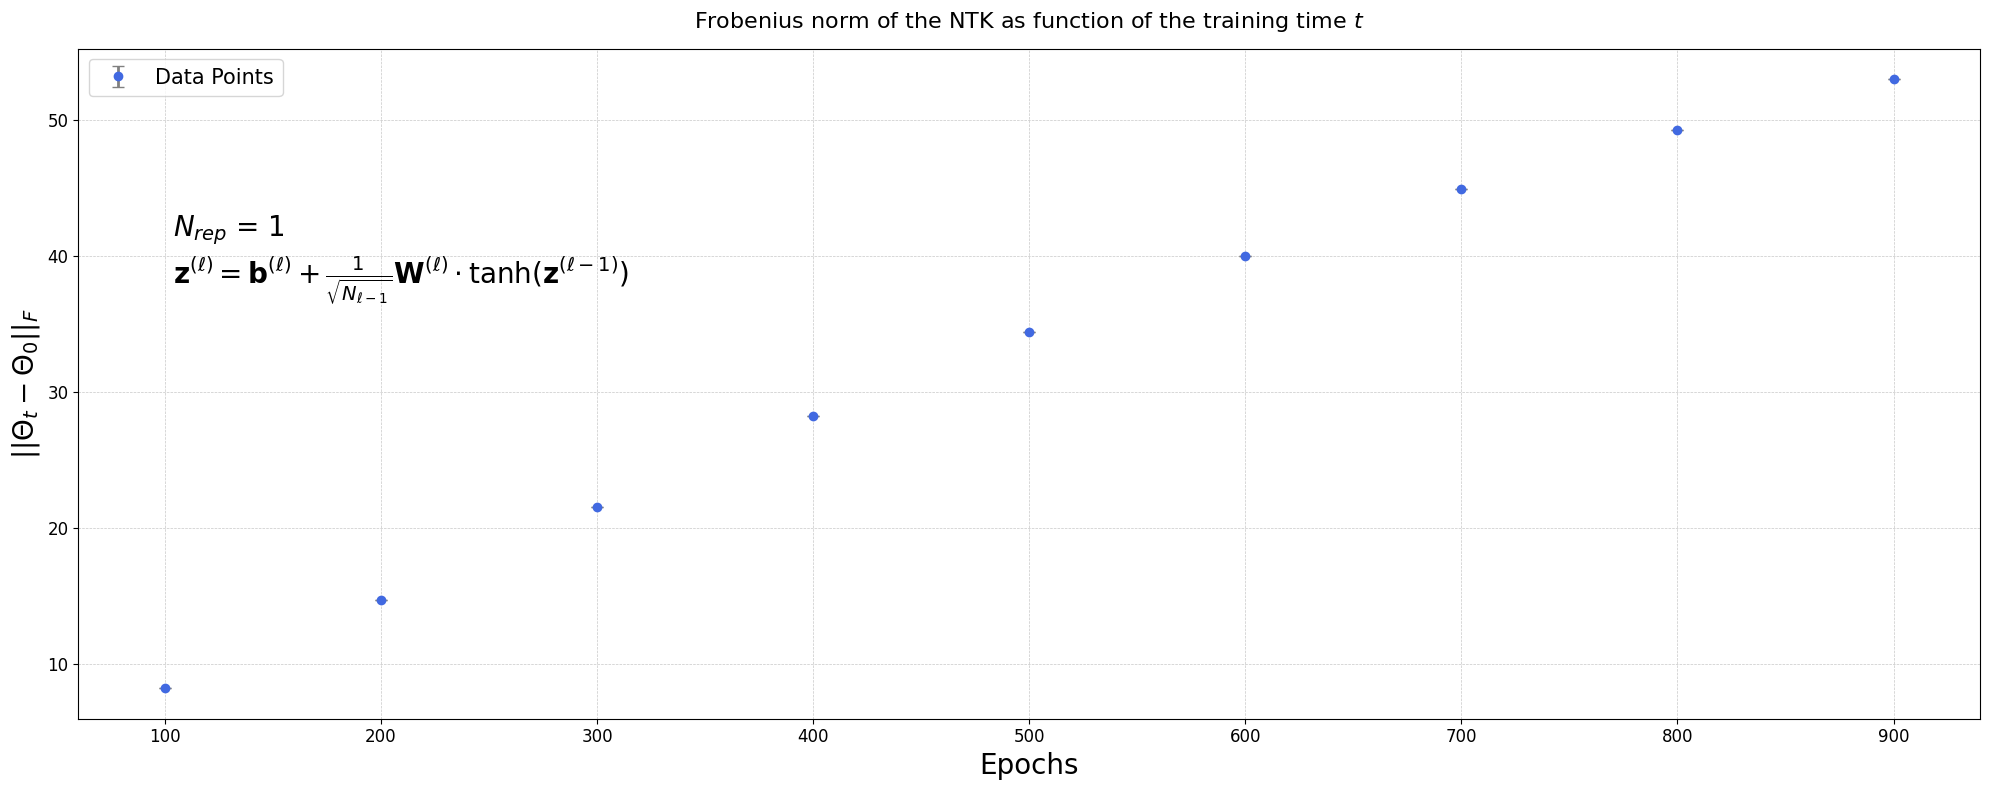

In [10]:
fig, ax = plt.subplots(figsize=(20,8))

ax.errorbar(results_by_rep[0][3][1:], delta_ntk_frob_means_by_steps, delta_ntk_frob_std_by_steps, fmt='o', label='Data Points', color='royalblue', ecolor='gray', elinewidth=2, capsize=4)

# Customize the grid
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Set title
ax.set_title(r'Frobenius norm of the NTK as function of the training time $t$', fontsize=16, pad=15)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.set_xlabel('Epochs', fontsize=20)
ax.set_ylabel(r'$|| \Theta_t - \Theta_0 ||_F$', fontsize=20)
ax.text(0.05, 0.72, r'$N_{rep}$ = ' + f'{nrep}', fontsize=20, transform=ax.transAxes)
ax.text(0.05, 0.65, r'$\mathbf{z}^{(\ell)} = \mathbf{b}^{(\ell)} + \frac{1}{\sqrt{N_{\ell-1}}} \mathbf{W}^{(\ell)} \cdot \tanh (\mathbf{z}^{(\ell - 1)})$', fontsize=20, transform=ax.transAxes)

# Add a legend
ax.legend(fontsize=15)
plt.tight_layout()
fig.savefig('NTK_training.pdf', dpi=300)

Construct matric $H$ defined as
$$
H = L(FK) \Theta_t \left[L (FK) \right]^T
$$

In [11]:
A = L @ FK
H = A @ NTK_mean_flat @ A.T

try:
    assert(np.allclose(H, H.T))
except AssertionError:
    print(f'Matrix H is not symmetric')
    H = 0.5 * (H + H.T)
    eigvals, eigvecs = np.linalg.eigh(H)
    eigvals = eigvals[::-1]
    eigvecs = eigvecs[:,::-1]
else:
  eigvals, eigvecs = np.linalg.eigh(H)
  eigvals = eigvals[::-1]
  eigvecs = eigvecs[:,::-1]

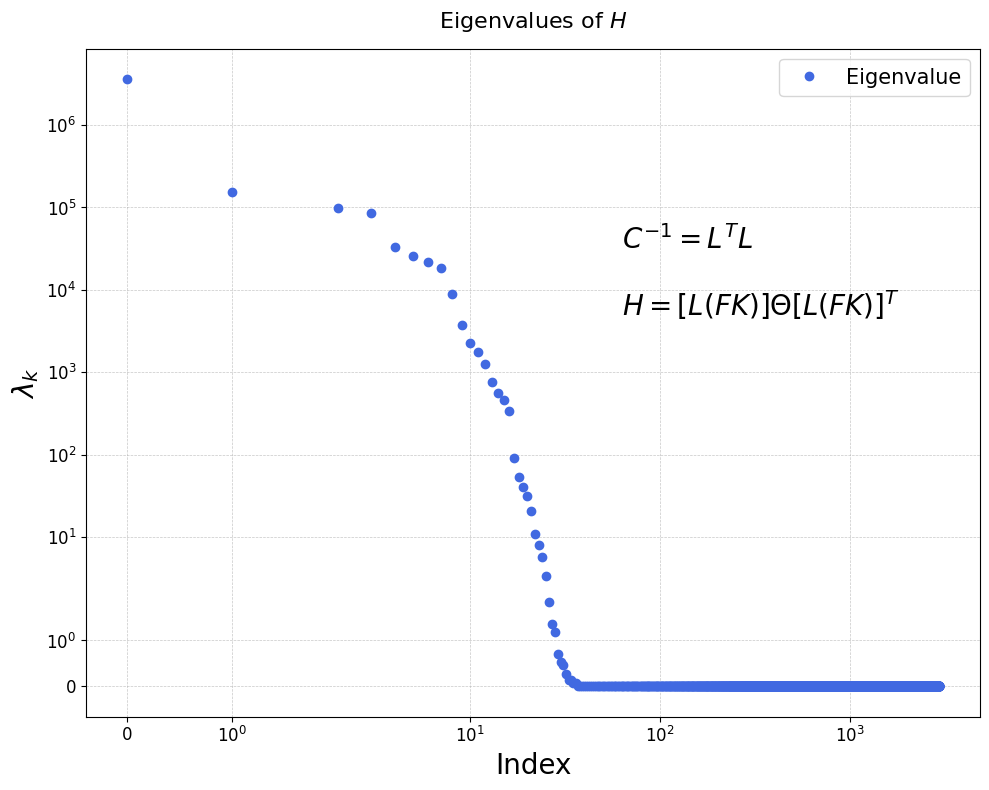

In [12]:
eigvals_reg = np.zeros_like(eigvals)

for i in range(eigvals.size):
  eigvals_reg[i] = round_float32(eigvals[i], eigvals[0], tol_magnitude=1.e-8)


fig, ax = plt.subplots(figsize=(10,8))

ax.plot(eigvals, label='Eigenvalue', color='royalblue', linestyle='', marker='o')

# Customize the grid
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Set title
ax.set_title(r'Eigenvalues of $H$', fontsize=16, pad=15)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Set labels
ax.set_xlabel('Index', fontsize=20)
ax.set_ylabel(r'$\lambda_k$', fontsize=20)

# Set scale
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.text(0.6, 0.70, r'$C^{-1} = L^T L$', fontsize=20, transform=ax.transAxes)
ax.text(0.6, 0.60, r'$H = [L (FK)] \Theta [L (FK)]^T$', fontsize=20, transform=ax.transAxes)

# Add a legend
ax.legend(fontsize=15)
plt.tight_layout()
fig.savefig('H_eigvals.pdf', dpi=300)

Construct the set of matrices
$$
\Theta_Y = (FK)^T \Theta (FK)\\[10pt]
\hat{\Theta}_Y = \Theta_Y C_Y^{-1} \\[10pt]
M = (FK)^T (FK)
$$

In [13]:
NTK_Y = FK @ NTK_mean_flat @ FK.T
NTK_hat_Y = NTK_Y @ Cinv
FK_FK= FK.T @ FK

In [14]:
# Check if NTK_Y is symmetric
try:
  assert(np.allclose(NTK_Y, NTK_Y.T))
except AssertionError:
  print('The matrix NTK_Y_hat is not symmetric')

eigvals_NTK_Y, eigvecs_NTK_Y = np.linalg.eig(NTK_Y)
eigvals_NTK_Y_reg = np.zeros_like(eigvals_NTK_Y)

for i in range(eigvals_NTK_Y.size):
  eigvals_NTK_Y_reg[i] = round_float32(eigvals_NTK_Y[i], eigvals_NTK_Y[0], tol_magnitude=1.e-8)

/opt/homebrew/Caskroom/miniconda/base/envs/nnpdf/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniconda/base/envs/nnpdf/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


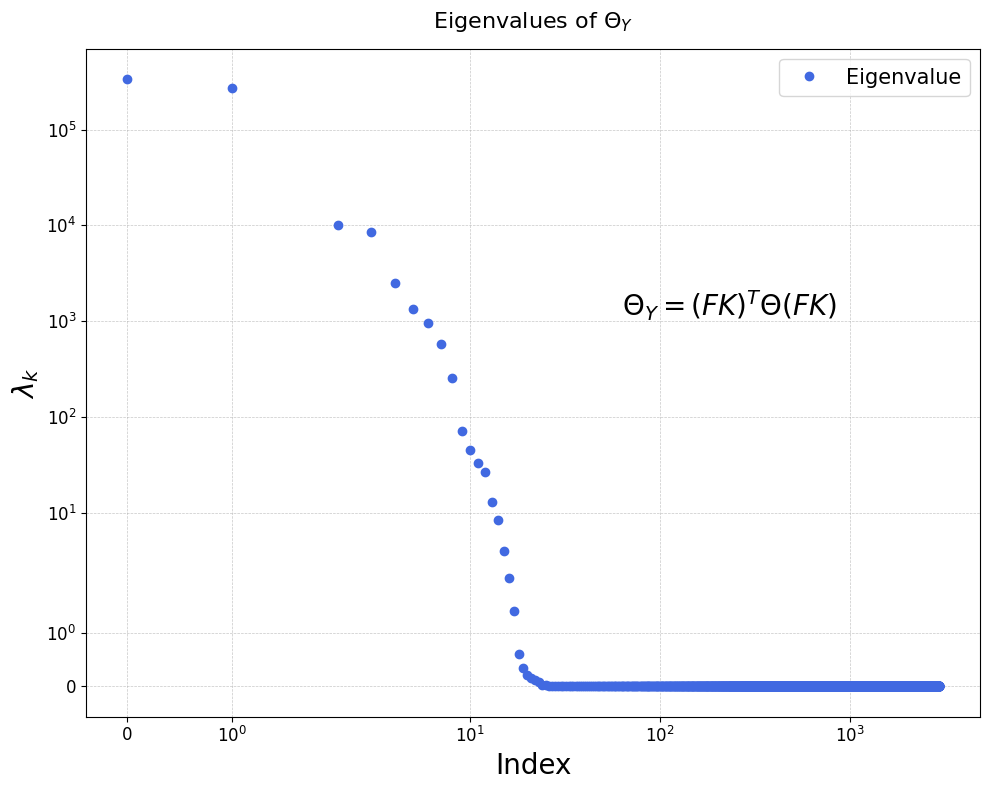

In [15]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(eigvals_NTK_Y, label='Eigenvalue', color='royalblue', linestyle='', marker='o')

# Customize the grid
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Set title
ax.set_title(r'Eigenvalues of $\Theta_Y$', fontsize=16, pad=15)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Set labels
ax.set_xlabel('Index', fontsize=20)
ax.set_ylabel(r'$\lambda_k$', fontsize=20)

# Set scale
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.text(0.6, 0.60, r'$\Theta_Y = (FK)^T \Theta (FK)$', fontsize=20, transform=ax.transAxes)

# Add a legend
ax.legend(fontsize=15)
plt.tight_layout()
fig.savefig('NTK_Y_eigvals.pdf', dpi=300)

In [16]:
# Check if M_luigi is symmetric
try:
  assert(np.allclose(FK_FK, FK_FK.T))
except AssertionError:
  print('The matrix NTK_Y_hat is not symmetric')

eigvals_FK_FK, eigvecs_FK_FK = np.linalg.eig(FK_FK)
eigvals_FK_FK_reg = np.zeros_like(eigvals_FK_FK)

for i in range(eigvals_FK_FK.size):
  eigvals_FK_FK_reg[i] = round_float32(eigvals_FK_FK[i], eigvals_FK_FK[0], tol_magnitude=1.e-8)

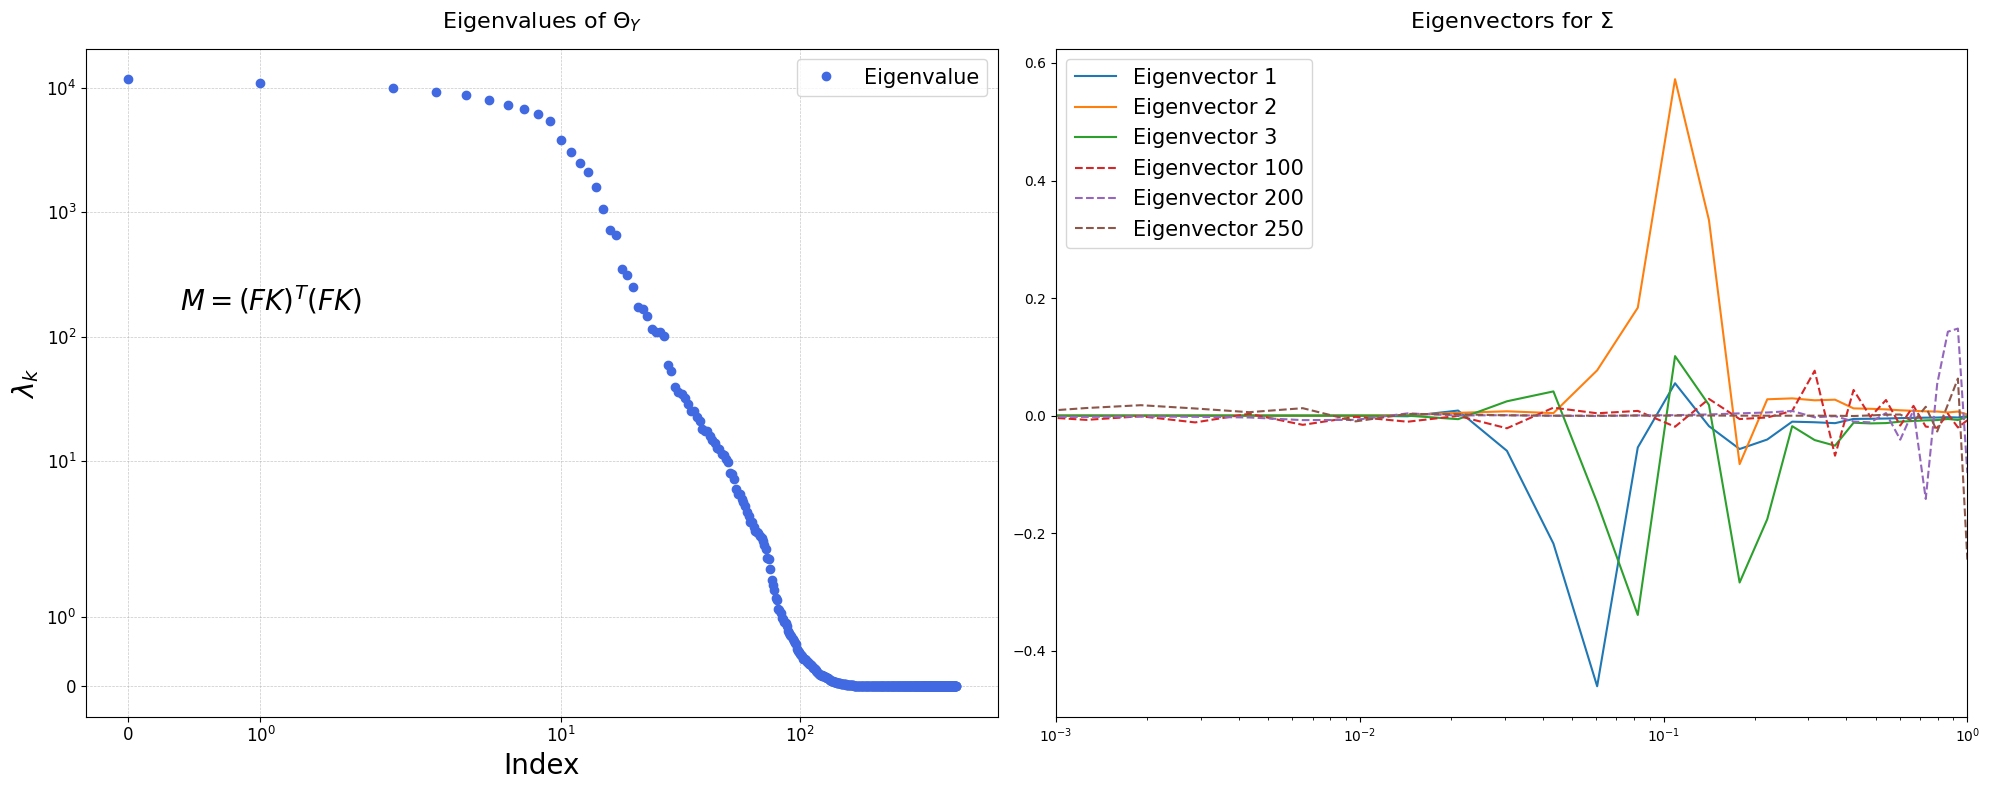

In [17]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

axs[0].plot(eigvals_FK_FK.real, label='Eigenvalue', color='royalblue', linestyle='', marker='o')

axs[1].plot(XGRID, eigvecs_FK_FK.real[:,0].reshape(oldshape[:2])[:,0], label='Eigenvector 1', linestyle='-')
axs[1].plot(XGRID, eigvecs_FK_FK.real[:,1].reshape(oldshape[:2])[:,0], label='Eigenvector 2', linestyle='-')
axs[1].plot(XGRID, eigvecs_FK_FK.real[:,2].reshape(oldshape[:2])[:,0], label='Eigenvector 3', linestyle='-')
axs[1].plot(XGRID, eigvecs_FK_FK.real[:,100].reshape(oldshape[:2])[:,0], label='Eigenvector 100', linestyle='--')
axs[1].plot(XGRID, eigvecs_FK_FK.real[:,200].reshape(oldshape[:2])[:,0], label='Eigenvector 200', linestyle='--')
axs[1].plot(XGRID, eigvecs_FK_FK.real[:,250].reshape(oldshape[:2])[:,0], label='Eigenvector 250', linestyle='--')

# Customize the grid
axs[0].grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Set title
axs[0].set_title(r'Eigenvalues of $\Theta_Y$', fontsize=16, pad=15)
axs[1].set_title(r'Eigenvectors for $\Sigma$', fontsize=16, pad=15)

# Customize ticks
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].tick_params(axis='both', which='minor', labelsize=10)

# Set labels
axs[0].set_xlabel('Index', fontsize=20)
axs[0].set_ylabel(r'$\lambda_k$', fontsize=20)

# Set scale
axs[0].set_xscale('symlog')
axs[0].set_yscale('symlog')
axs[1].set_xscale('log')

# Text
axs[0].text(0.1, 0.60, r'$M = (FK)^T (FK)$', fontsize=20, transform=ax.transAxes)

axs[1].set_xlim([1.e-3,1.])

# Add a legend
axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)

plt.tight_layout()
fig.savefig('NTK_Y_eigvals.pdf', dpi=300)

In [18]:
# Check if NTK_hat_Y is symmetric
try:
  assert(np.allclose(NTK_hat_Y, NTK_hat_Y.T))
except AssertionError:
  print('The matrix NTK_Y_hat is not symmetric')

NTK_hat_Y_l_svd, NTK_hat_Y_sv, NTK_hat_Y_r_svd = np.linalg.svd(NTK_hat_Y)

The matrix NTK_Y_hat is not symmetric


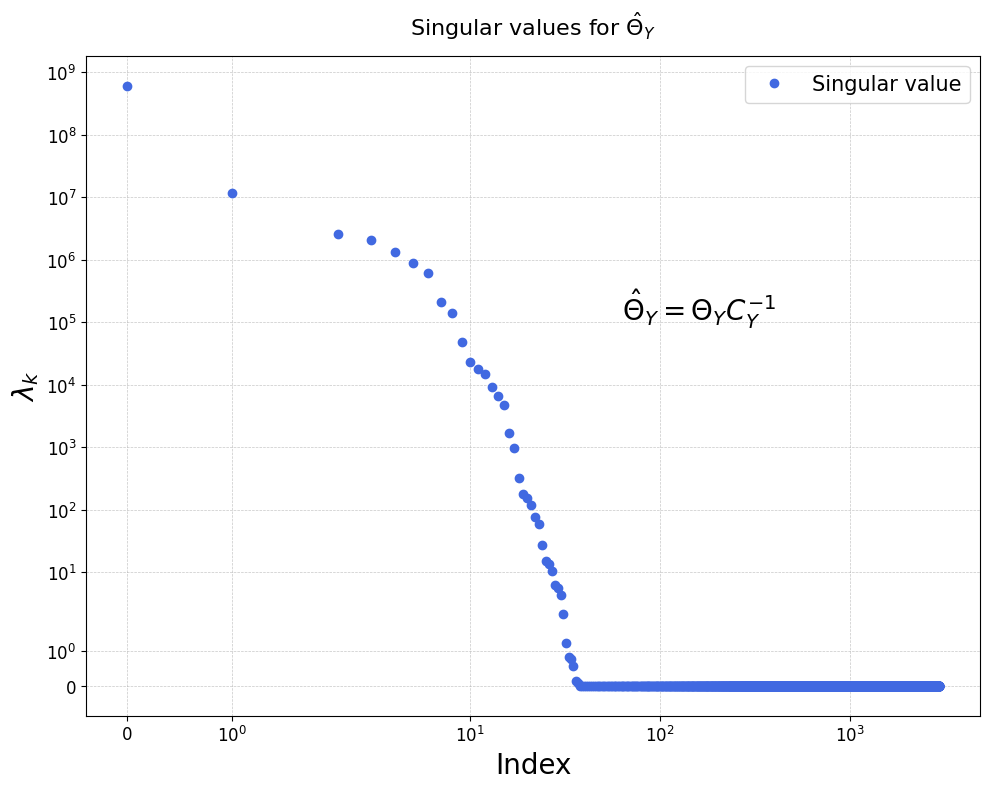

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(NTK_hat_Y_sv, label='Singular value', color='royalblue', linestyle='', marker='o')

# Customize the grid
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Set title
ax.set_title(r'Singular values for $\hat{\Theta}_Y$', fontsize=16, pad=15)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Set labels
ax.set_xlabel('Index', fontsize=20)
ax.set_ylabel(r'$\lambda_k$', fontsize=20)

# Set scale
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.text(0.6, 0.60, r'$\hat{\Theta}_Y = \Theta_Y C_Y^{-1}$', fontsize=20, transform=ax.transAxes)

# Add a legend
ax.legend(fontsize=15)
plt.tight_layout()
fig.savefig('NTK_Y_hat_sv.pdf', dpi=300)

# Evolution of the data

In [ ]:
from functools import lru_cache
import time

# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError
  
eps_0_rep = [Y.to_numpy()[:,0] - FK @ f0.flatten() for f0 in f0_rep]
Ly = (L @ Y).to_numpy()[:,0]
#Af0 = A @ f0.flatten()
L_eps0_rep = [L @ eps_0 for eps_0 in eps_0_rep]
L_eps0_av = np.mean(L_eps0_rep, axis=0)

L_eps0_tilde = [np.dot(L_eps0_av, eigvecs[:,k]) for k in range(eigvecs.shape[1])]

pre_computed_coefficients = [Linv @ eigvecs[:,k] * L_eps0_tilde[k] for k in range(eigvals_reg.size)] 

@lru_cache(maxsize=None)
def preds_t(t, learning_rate = 0.00001):
  predictions = [pre_computed_coefficients[k] * np.exp(-eigvals_reg[k] * learning_rate* t) for k in range(eigvals_reg.size)] 
  predictions = np.sum(predictions, axis=0)

  predictions = pd.DataFrame(predictions, index=Y.index)
  predictions = Y - predictions
  return predictions

In [21]:
pred_in_time = results_by_rep[0][1]
pdfs_in_time = results_by_rep[0][2]

# The two predictions at time 0 should be the same
np.allclose(pdfs_in_time[0].numpy(), f0_rep[0])

True

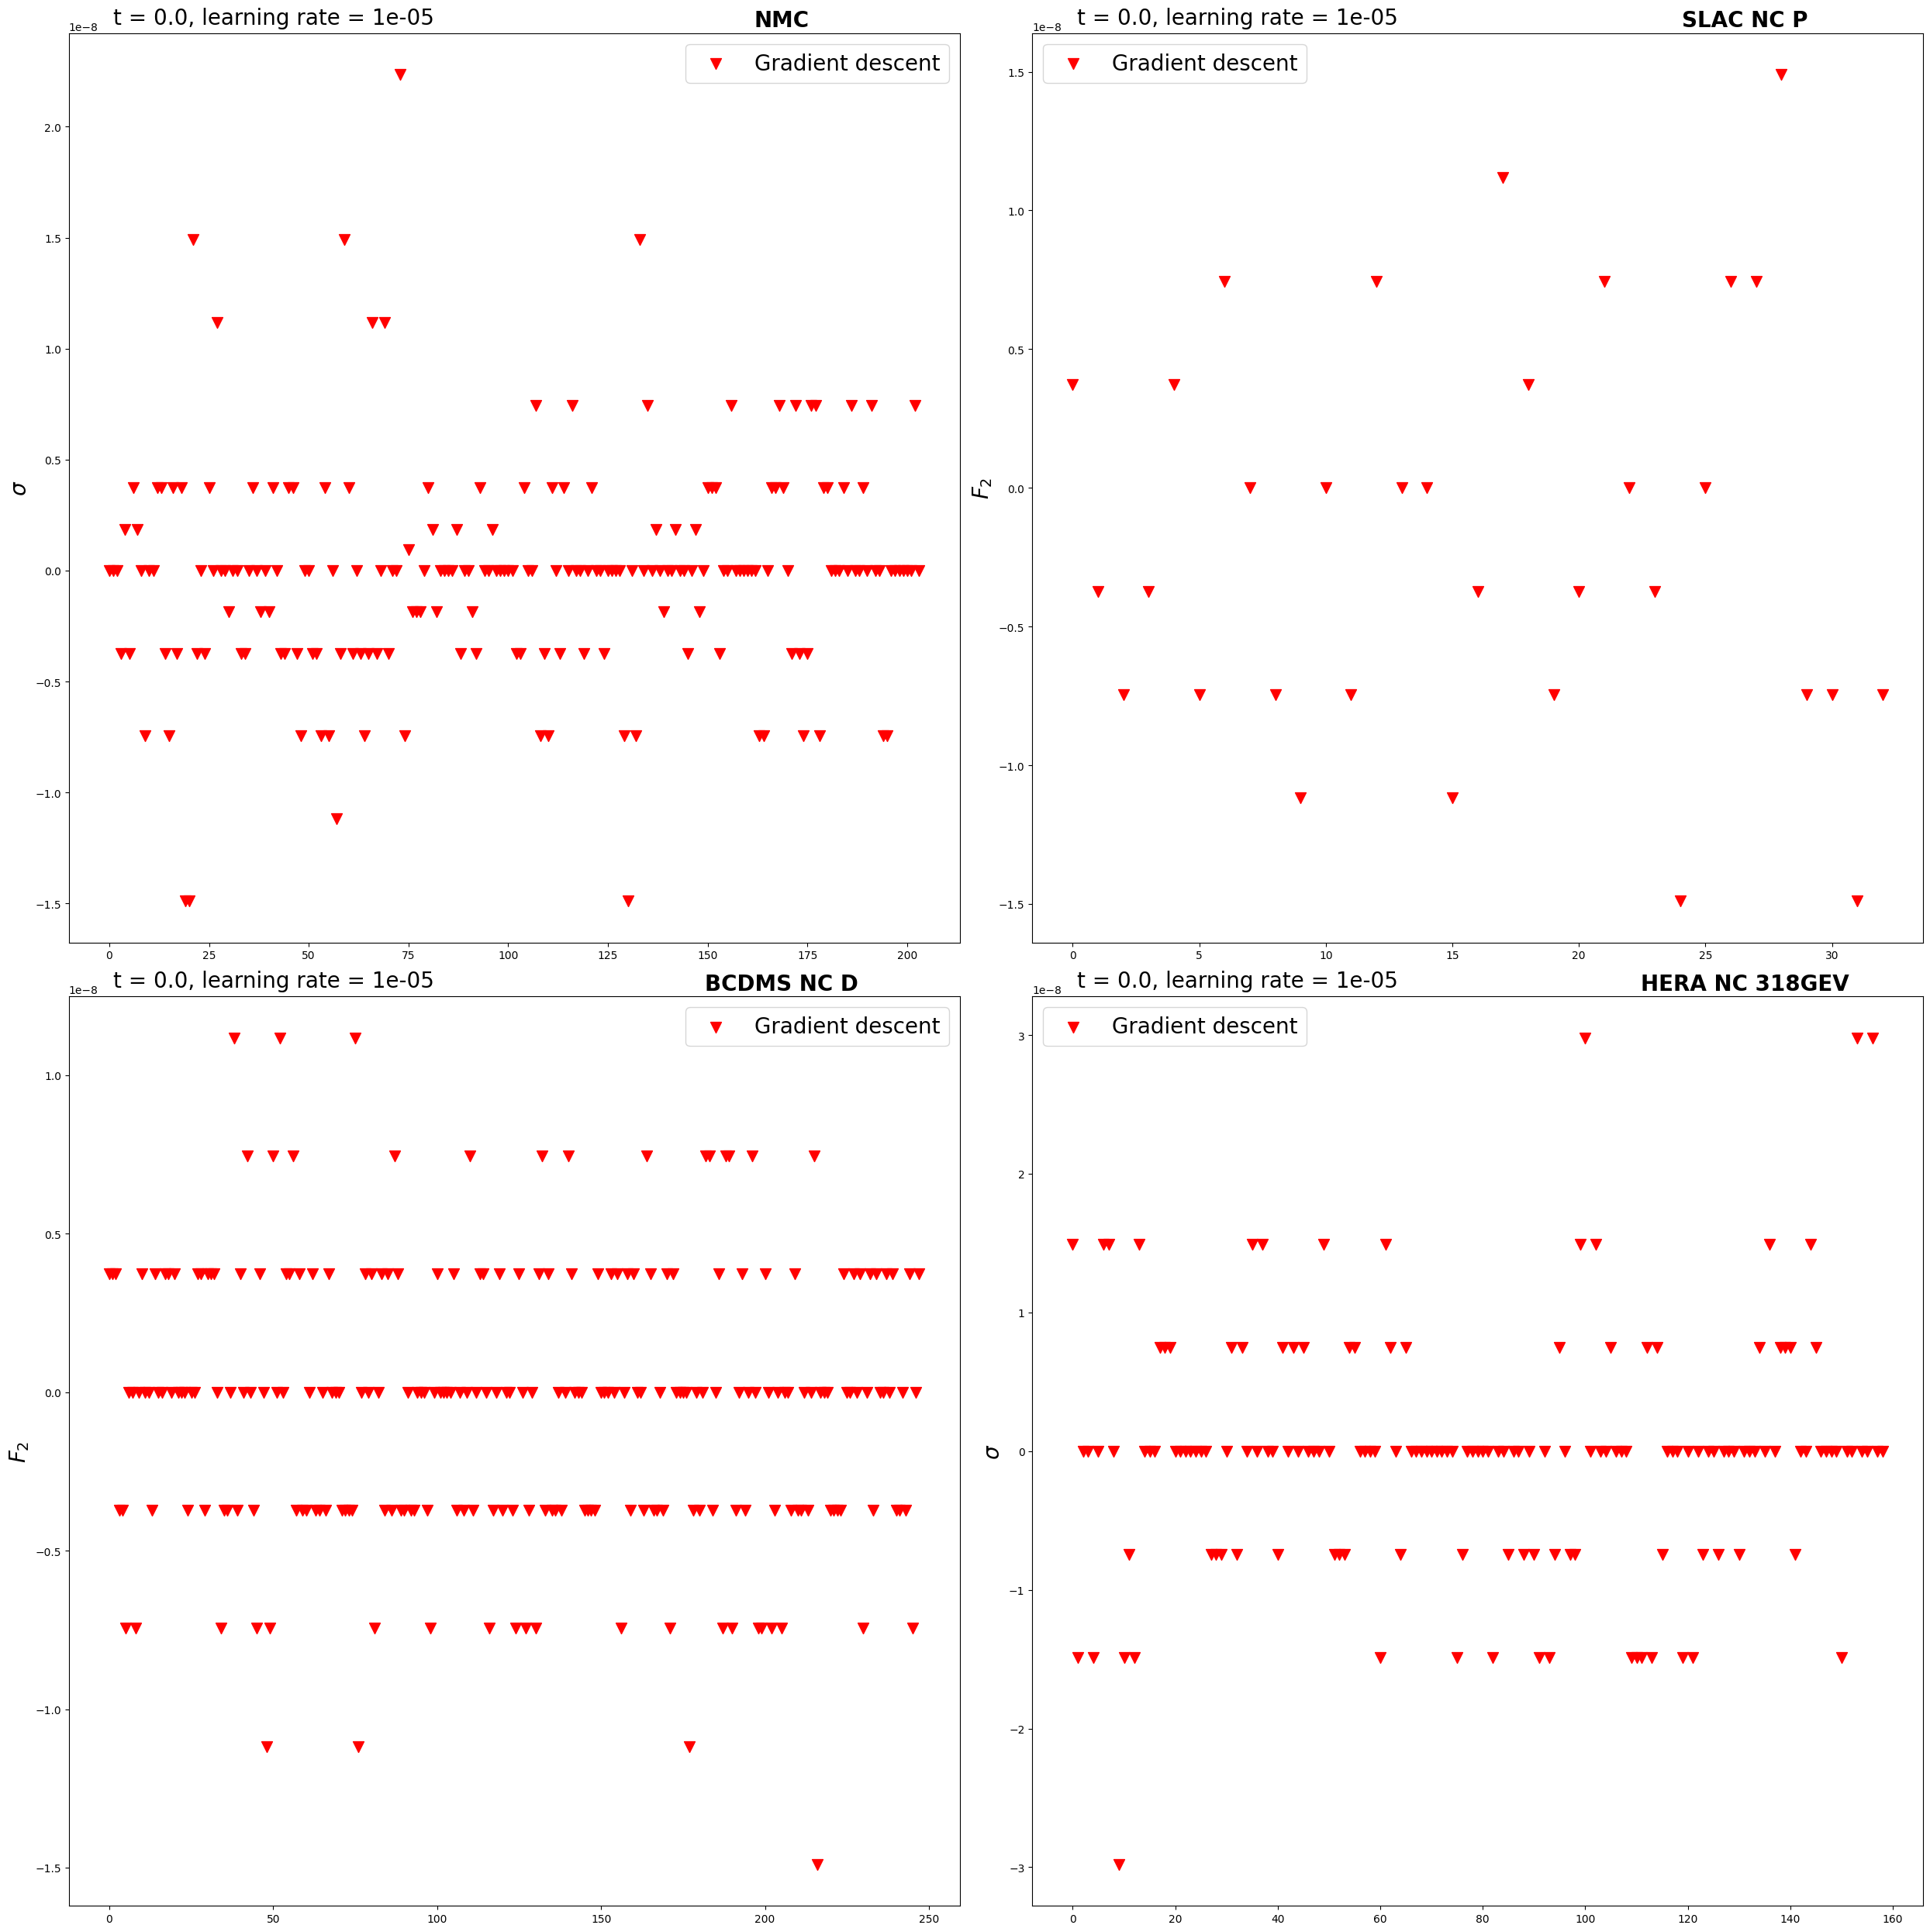

In [ ]:
experiments = ['NMC_NC_NOTFIXED_P_EM-SIGMARED', 'SLAC_NC_NOTFIXED_P_EM-F2', 'BCDMS_NC_NOTFIXED_D_EM-F2', 'HERA_NC_318GEV_EM-SIGMARED']
exp_titles = ['NMC', 'SLAC NC P', 'BCDMS NC D', 'HERA NC 318GEV']
y_labels = [r'$\sigma$', r'$F_2$', r'$F_2$', r'$\sigma$']
t = 0.
fig, axes = plt.subplots(2, 2, figsize=(25, 25))  # Adjust figsize for desired plot size
preds = preds_t(t, learning_rate=learning_rate_gd)
for i, ax in enumerate(axes.flat):
    y = Y.xs(level='dataset', key=experiments[i]).to_numpy()
    p = preds.xs(level='dataset', key=experiments[i]).to_numpy()
    trained_pred = pred_in_time[0][experiments[i]]
    #ax.scatter(np.arange(y.size), y, color='green', label='Central data', marker='o', s=100)
    #ax.scatter(np.arange(y.size), p, color='orange', label='Analytical solution', marker='^', s=100)
    #ax.scatter(np.arange(y.size), trained_pred, color='red', label='Gradient descent', marker='v', s=100)
    ax.scatter(np.arange(y.size), trained_pred - p[:,0], color='red', label='Gradient descent', marker='v', s=100)
    #ax.set_xlabel(r'$x$')
    ax.set_ylabel(y_labels[i], fontsize=20)
    #ax.set_xscale('log')
    ax.set_title(exp_titles[i], x=0.8,fontsize=20, fontweight='bold')
    ax.legend(fontsize=20)
    ax.text(0.05, 1.01, f't = {t}, learning rate = {learning_rate_gd}', fontsize=20, transform=ax.transAxes)


plt.tight_layout()
fig.savefig('data_evolution.pdf')

# Compare GD and GF for $\epsilon_t$